In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

from pathlib import Path
import pandas as pd

image_dir = Path('/Users/nijat/Downloads/split_data/')


filepaths = list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r"**/**/*.png"))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

image_df = image_df.sample(frac=1).reset_index(drop=True)

image_df['dataset'] = image_df['Filepath'].apply(lambda x: x.split('/')[-3])

train_df = image_df[image_df['dataset']=='train']
test_df = image_df[image_df['dataset']=='test']

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Ignore errors if no GPU is found
  pass

print(physical_devices)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    validation_split=0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224), 
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),  
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),  
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 3245 validated image filenames belonging to 10 classes.
Found 811 validated image filenames belonging to 10 classes.
Found 1019 validated image filenames belonging to 10 classes.


In [2]:
pretrained_model = EfficientNetV2B3(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)  # Update input shape as required
    #pooling='avg'
)
pretrained_model.trainable = False
pretrained_model.summary()

output = pretrained_model.output

# Apply the new Conv2d block to the output
x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block6_conv1')(output)
x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block6_conv2')(x)
x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', name='block6_conv3')(x)
x = tf.keras.layers.GlobalAveragePooling2D(name='block6_gap')(x)
x = tf.keras.layers.Flatten(name='block7_flatten')(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)

# Create a new model with the combined layers
model = tf.keras.Model(inputs=pretrained_model.input, outputs=x, name='LungNet22')
model.summary()

2024-04-18 16:19:58.737511: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-04-18 16:19:58.737534: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-04-18 16:19:58.737539: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-04-18 16:19:58.737578: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-18 16:19:58.737598: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "efficientnetv2-b3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 40)         1080      ['normalizatio

In [3]:
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [4]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=300,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

Epoch 1/300


2024-04-18 16:20:08.045504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - ETA: 0s - loss: 1.9141 - accuracy: 0.3741

2024-04-18 16:20:18.074214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - 16s 119ms/step - loss: 1.9141 - accuracy: 0.3741 - val_loss: 1.2889 - val_accuracy: 0.5203
Epoch 2/300
102/102 [==============================] - 9s 84ms/step - loss: 1.0571 - accuracy: 0.6166 - val_loss: 0.8401 - val_accuracy: 0.6942
Epoch 3/300
102/102 [==============================] - 9s 84ms/step - loss: 0.7010 - accuracy: 0.7522 - val_loss: 0.6717 - val_accuracy: 0.7731
Epoch 4/300
102/102 [==============================] - 9s 85ms/step - loss: 0.5045 - accuracy: 0.8268 - val_loss: 0.4875 - val_accuracy: 0.8261
Epoch 5/300
102/102 [==============================] - 9s 83ms/step - loss: 0.4139 - accuracy: 0.8622 - val_loss: 0.5712 - val_accuracy: 0.8286
Epoch 6/300
102/102 [==============================] - 8s 82ms/step - loss: 0.3294 - accuracy: 0.8854 - val_loss: 0.4665 - val_accuracy: 0.8718
Epoch 7/300
102/102 [==============================] - 8s 81ms/step - loss: 0.2766 - accuracy: 0.9005 - val_loss: 0.6774 - val_accuracy: 0.7830
Ep

In [5]:
model.save('EfficientNetV2B3_LungNet22.keras')

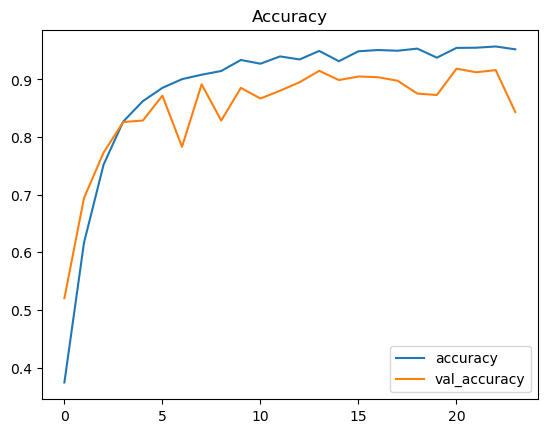

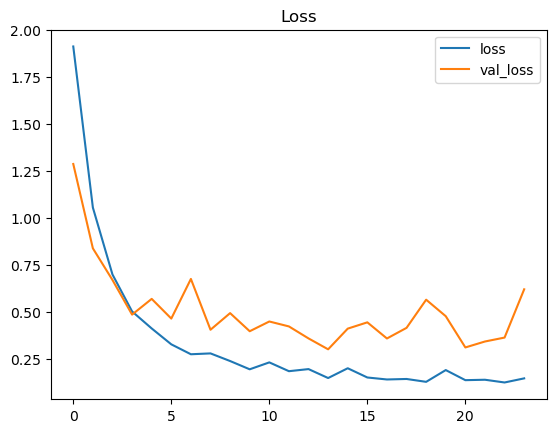

    Test Loss: 0.25529
Test Accuracy: 92.93%


In [6]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()


pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()


results = model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [7]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]
print(f'The first 6 predictions: {pred[:6]}')

2024-04-18 16:24:17.449539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 4s 89ms/step
The first 6 predictions: ['covid', 'nodule', 'nodule', 'nodule', 'tuberculosis', 'lung Opacity']


                    precision    recall  f1-score   support

           control       0.99      1.00      1.00       116
             covid       0.98      0.96      0.97       101
          effusion       0.94      0.85      0.89       100
      lung Opacity       0.96      0.97      0.97       100
              mass       0.96      0.88      0.92       101
            nodule       0.95      0.83      0.89       101
         pneumonia       0.78      0.97      0.87       100
      pneumothorax       0.85      0.95      0.90       100
pulmunary fibrosis       0.97      0.91      0.94        99
      tuberculosis       0.95      0.96      0.96       101

          accuracy                           0.93      1019
         macro avg       0.93      0.93      0.93      1019
      weighted avg       0.93      0.93      0.93      1019



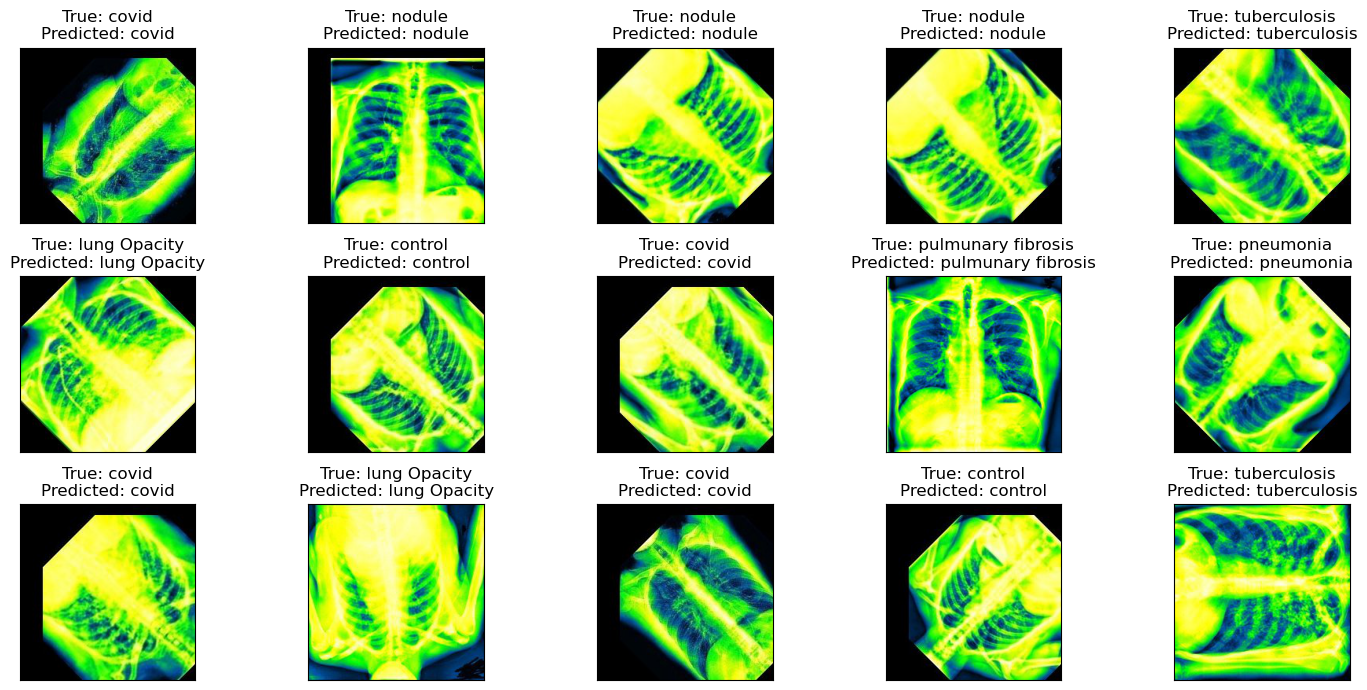

In [8]:
from sklearn.metrics import classification_report

y_test = list(test_df.Label)
print(classification_report(y_test, pred))

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                         subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()